In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# me defined 
from dataloader import DatasetGenerator as dg
from modeling import ModelBuilder as mb
from evaluation import Evaluator as ev

Synthetic Data

In [2]:
# 4 input values, each Gaussian distributed with 0 mean and 1 stdev
# 1 output value, distance from the origin, AKA L2-norm
# 1000 instances for training, 1000 for testing

(1000,)
min_val y in before norm:  0.23861535417801807
max_val y in before norm:  4.333480263835895
(1000,)
min_val y in before norm:  0.42262818639953165
max_val y in before norm:  3.9830282666886734
X_train:  [[ 0.44047937  0.76369199 -1.27541153  0.78855772]
 [-1.2198779   0.76237126  0.46014377  0.69485695]
 [-1.66984957  0.88978325  2.21900534 -3.13344002]
 [-0.39147358 -0.97940547  0.34547645 -2.0774028 ]]
y_train:  [0.73304085 0.69544365 1.97411572 1.03382443]
X_test:  [[ 0.94672593  0.34283458  1.12364257 -0.47806116]
 [ 0.87853063 -0.24175457 -0.36702788 -1.06127545]
 [ 1.42189605 -1.10392036 -1.19212676  0.90574864]
 [-0.73868798  0.469975    0.48805972  0.30013674]]
y_test:  [0.65165274 0.57493338 1.07781914 0.35035875]
min_val y in after norm:  0.0
max_val y in after norm:  2.0


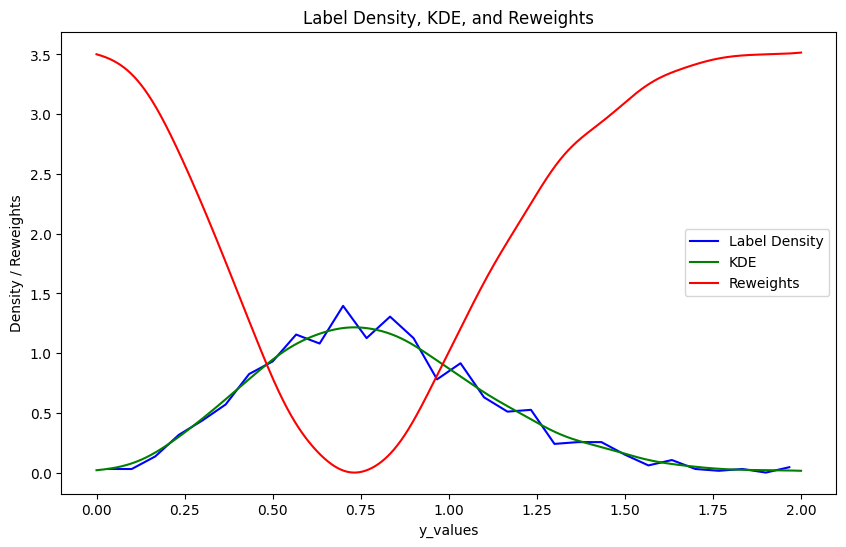

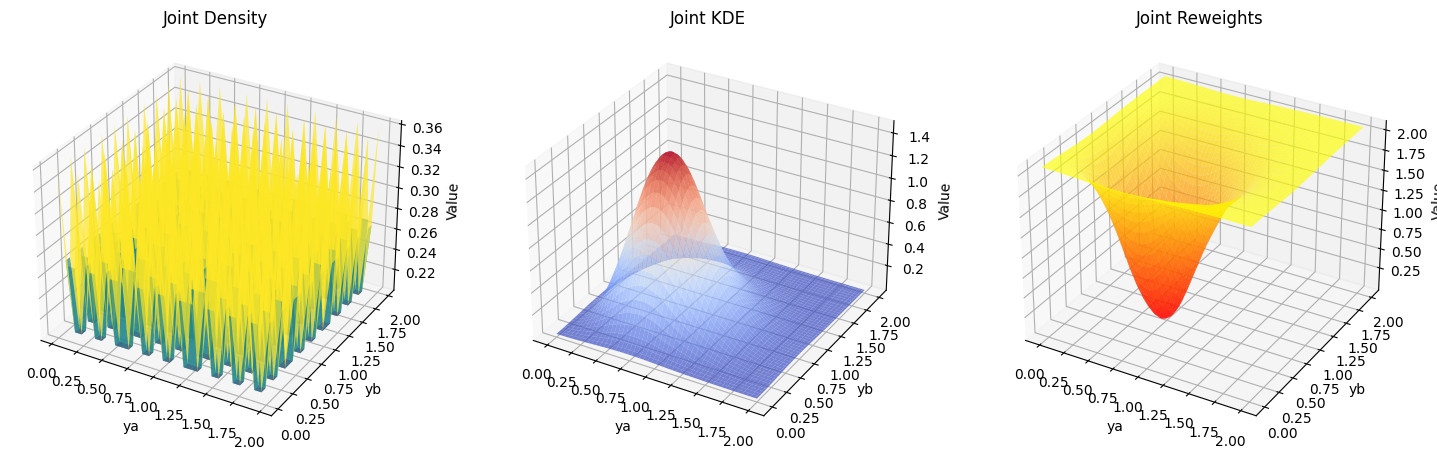

0.0 2.0


In [2]:
# Generate synthetic data
n_train = 1000
n_test = 1000
loader = dg(n_train, n_test)
print(loader.min_y, loader.max_y)

In [3]:
# print first 4 of reweights 
print(loader.reweights[:4])
# print first 4 of jreweights
print(loader.jreweights[:4])

[3.51463969e-07 2.26537281e-02 3.50854228e+00 1.20942982e+00]
[0.0131749  2.04075847 0.70346883 1.41651587]


Model Building

In [4]:
# NN for representation learning:
# 4 input nodes
# 1 or more hidden layers
# the last hidden layer has 2 nodes (representation layer Z)
# plot the instances in the 2D feature/representation space of Z 
# use different colors for different target values (can be in groups, each group with a different color) similar to the RankSim pictures
# training and test sets in different plots.
# expecting the instances to be in a semi-circle
# for prediction, add output layer of 1 node.

mb = mb()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0     

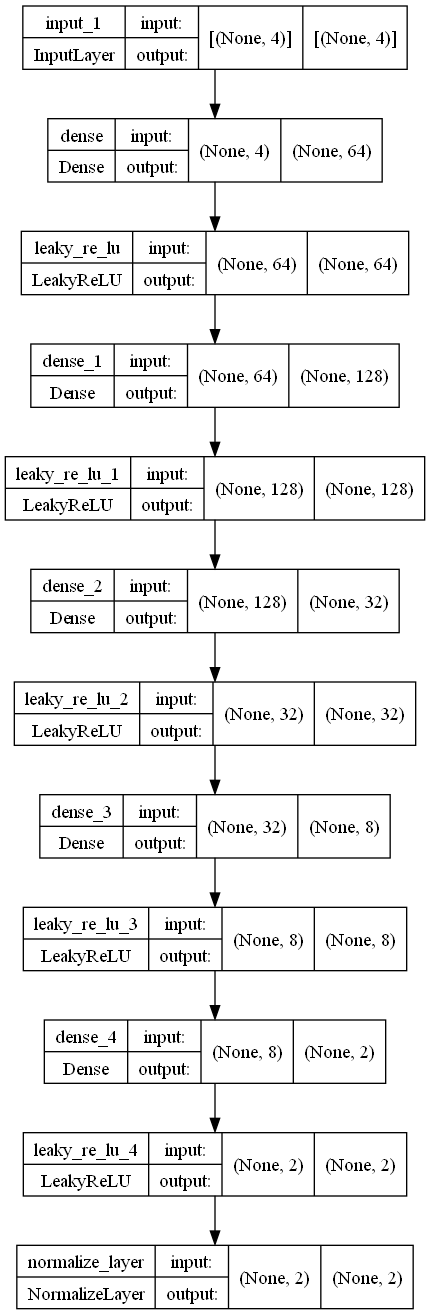

In [5]:
# Create and train the model
hiddens = [64, 128, 32, 8]
model = mb.create_model_feat(4, 2, hiddens)
# summarize and plot the model
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Test of First Idea improving on ranksim

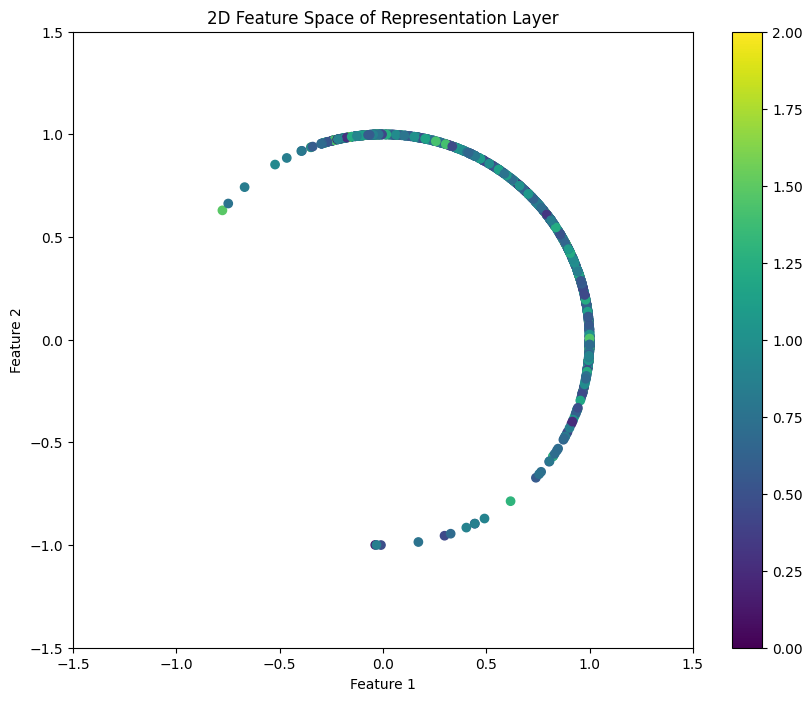

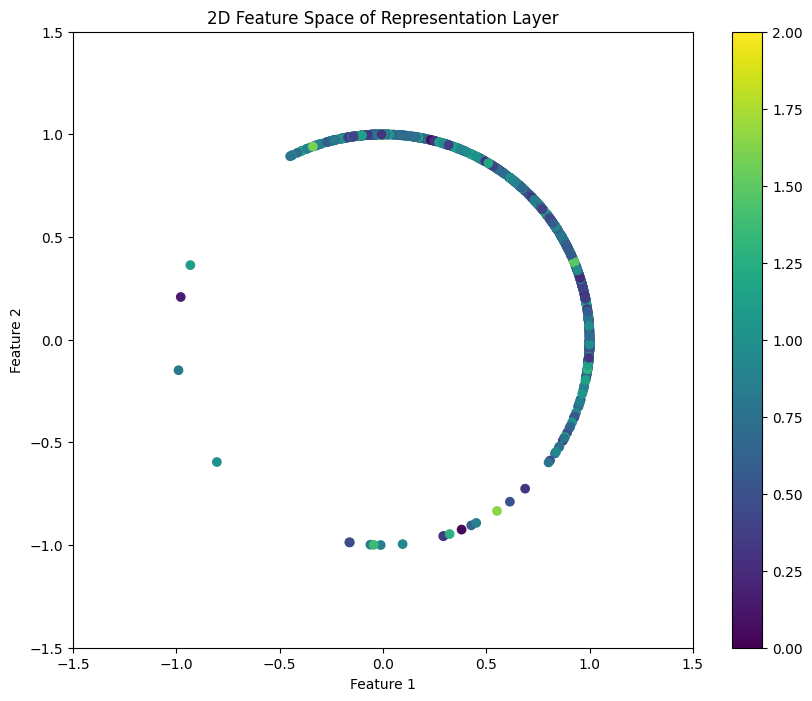

In [6]:
eva = ev()
# Plot the 2D feature space
eva.plot_feature_space(model, loader.X_train, loader.y_train)
eva.plot_feature_space(model, loader.X_test, loader.y_test)

Run the command line:
 tensorboard --logdir logs/fit
Epoch 1/400
44/44 [==============================] - 11s 181ms/step - loss: 20.1416 - val_loss: 15.3930
Epoch 2/400
44/44 [==============================] - 8s 178ms/step - loss: 14.0246 - val_loss: 14.6771
Epoch 3/400
44/44 [==============================] - 8s 176ms/step - loss: 14.4784 - val_loss: 14.6878
Epoch 4/400
44/44 [==============================] - 8s 173ms/step - loss: 13.7445 - val_loss: 14.8666
Epoch 5/400
44/44 [==============================] - 8s 171ms/step - loss: 13.3898 - val_loss: 14.9765
Epoch 6/400
44/44 [==============================] - 8s 182ms/step - loss: 12.9166 - val_loss: 14.7345
Epoch 7/400
44/44 [==============================] - 7s 165ms/step - loss: 13.0670 - val_loss: 14.1941
Epoch 8/400
44/44 [==============================] - 8s 177ms/step - loss: 12.2817 - val_loss: 13.2709
Epoch 9/400
44/44 [==============================] - 8s 171ms/step - loss: 11.5807 - val_loss: 10.7645
Epoch 10/400
44/44 

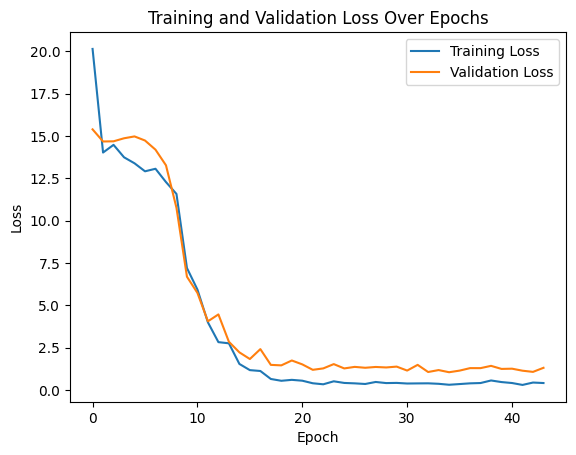

Epoch 1/35
63/63 [==============================] - 11s 156ms/step - loss: 1.8344
Epoch 2/35
63/63 [==============================] - 10s 158ms/step - loss: 1.4423
Epoch 3/35
63/63 [==============================] - 10s 160ms/step - loss: 0.7368
Epoch 4/35
63/63 [==============================] - 10s 158ms/step - loss: 0.7579
Epoch 5/35
63/63 [==============================] - 10s 159ms/step - loss: 1.2812
Epoch 6/35
63/63 [==============================] - 10s 166ms/step - loss: 0.8244
Epoch 7/35
63/63 [==============================] - 10s 158ms/step - loss: 0.6398
Epoch 8/35
63/63 [==============================] - 10s 156ms/step - loss: 0.5805
Epoch 9/35
63/63 [==============================] - 10s 159ms/step - loss: 0.5956
Epoch 10/35
63/63 [==============================] - 10s 155ms/step - loss: 1.0820
Epoch 11/35
63/63 [==============================] - 10s 160ms/step - loss: 0.4947
Epoch 12/35
63/63 [==============================] - 10s 158ms/step - loss: 0.4980
Epoch 13/35
6

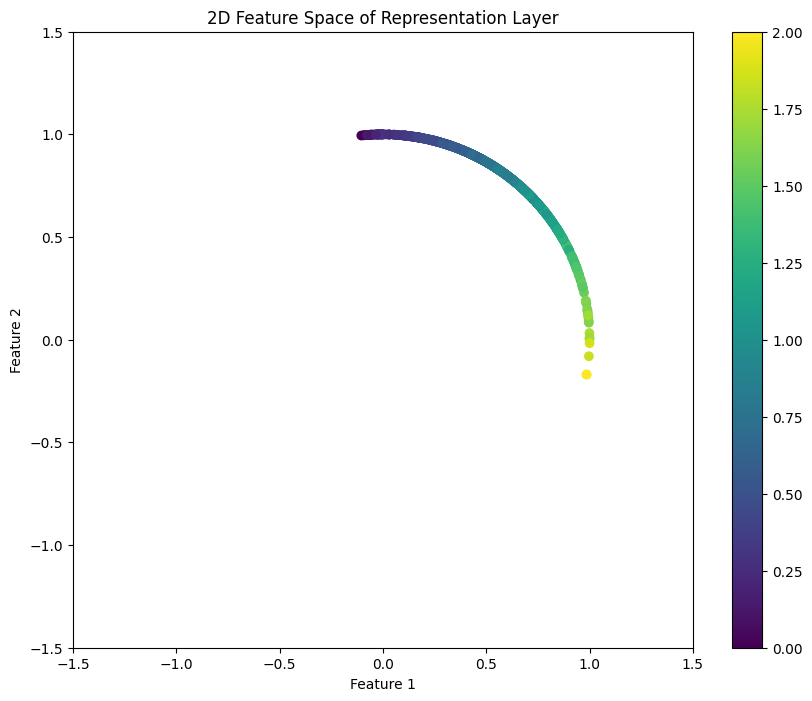

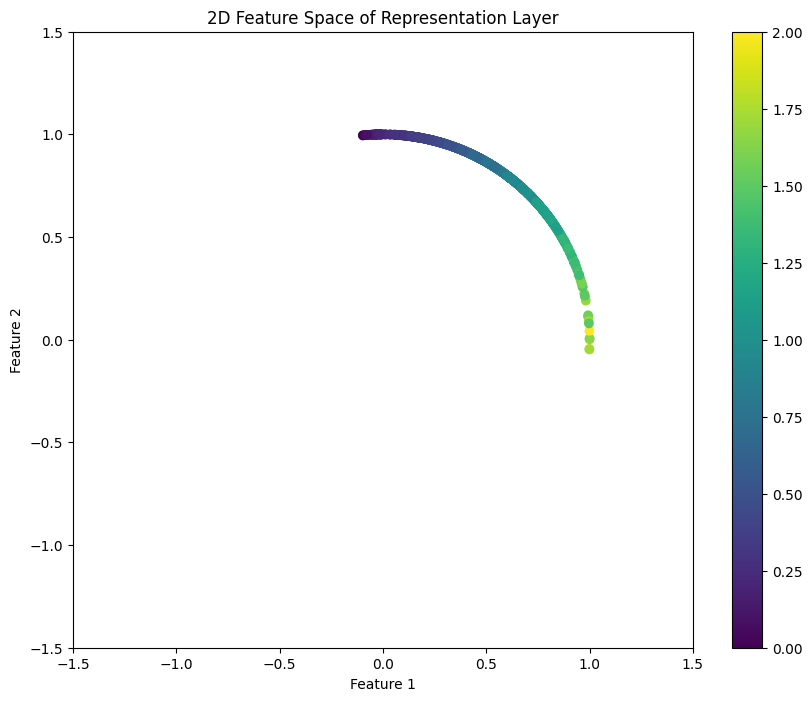

In [7]:
history = mb.train_features(model, loader.X_train, loader.y_train, learning_rate=1e-3, epochs=400, batch_size=16)

# plot_feature_space(model, X_train, y_train)
# Plot the 2D feature space
eva.plot_feature_space(model, loader.X_train, loader.y_train)
eva.plot_feature_space(model, loader.X_test, loader.y_test)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0   

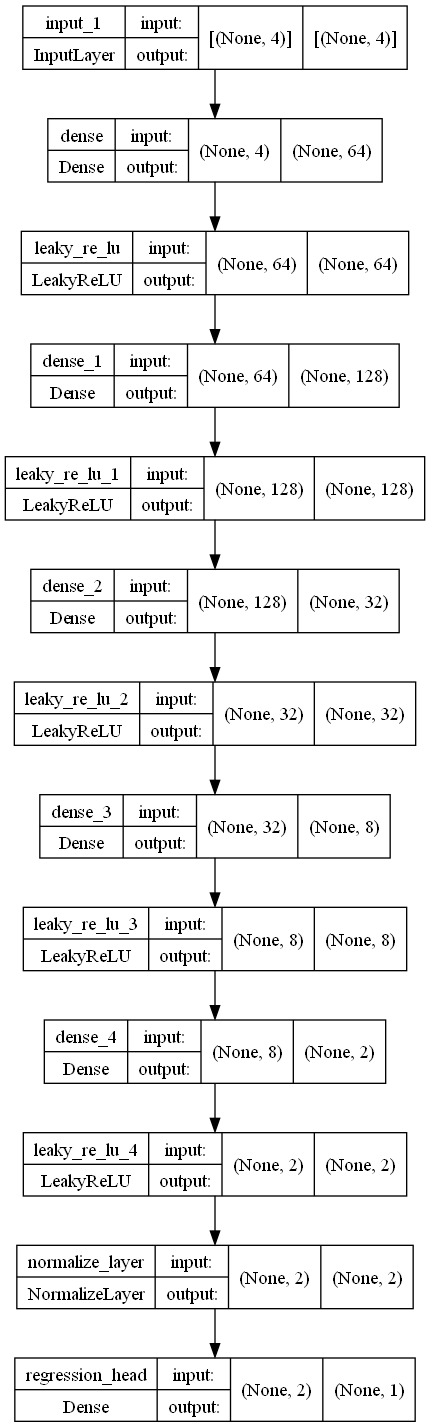

In [8]:
# add regression head
extended_model = mb.add_regression_head(model)
# summarize and plot the model
extended_model.summary()
tf.keras.utils.plot_model(extended_model, show_shapes=True)

Run the command line:
 tensorboard --logdir logs/fit
Epoch 1/400
44/44 [==============================] - 2s 20ms/step - loss: 0.4602 - regression_head_loss: 0.4602 - regression_head_mse: 0.4884 - val_loss: 0.3065 - val_regression_head_loss: 0.3065 - val_regression_head_mse: 0.3115
Epoch 2/400
44/44 [==============================] - 1s 12ms/step - loss: 0.2095 - regression_head_loss: 0.2095 - regression_head_mse: 0.2062 - val_loss: 0.1420 - val_regression_head_loss: 0.1420 - val_regression_head_mse: 0.1251
Epoch 3/400
44/44 [==============================] - 1s 20ms/step - loss: 0.1007 - regression_head_loss: 0.1007 - regression_head_mse: 0.0839 - val_loss: 0.0773 - val_regression_head_loss: 0.0773 - val_regression_head_mse: 0.0550
Epoch 4/400
44/44 [==============================] - 1s 12ms/step - loss: 0.0561 - regression_head_loss: 0.0561 - regression_head_mse: 0.0377 - val_loss: 0.0469 - val_regression_head_loss: 0.0469 - val_regression_head_mse: 0.0268
Epoch 5/400
44/44 [========

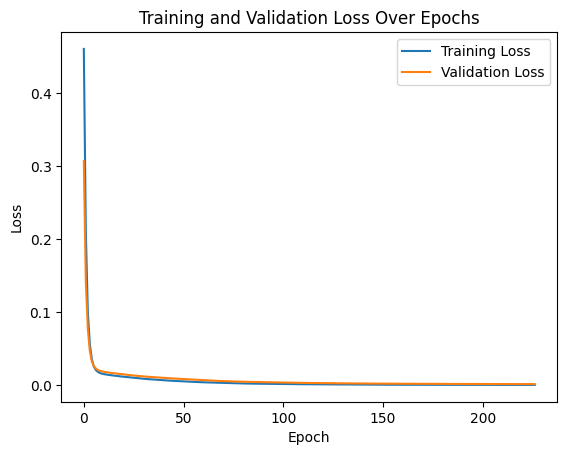

Epoch 1/218
63/63 [==============================] - 1s 7ms/step - loss: 5.6956e-04 - regression_head_loss: 5.6956e-04 - regression_head_mse: 2.4546e-04
Epoch 2/218
63/63 [==============================] - 0s 6ms/step - loss: 5.0512e-04 - regression_head_loss: 5.0512e-04 - regression_head_mse: 2.1539e-04
Epoch 3/218
63/63 [==============================] - 0s 5ms/step - loss: 4.5672e-04 - regression_head_loss: 4.5672e-04 - regression_head_mse: 1.9911e-04
Epoch 4/218
63/63 [==============================] - 0s 6ms/step - loss: 4.4014e-04 - regression_head_loss: 4.4014e-04 - regression_head_mse: 1.9679e-04
Epoch 5/218
63/63 [==============================] - 0s 5ms/step - loss: 4.2861e-04 - regression_head_loss: 4.2861e-04 - regression_head_mse: 2.0386e-04
Epoch 6/218
63/63 [==============================] - 0s 5ms/step - loss: 3.9701e-04 - regression_head_loss: 3.9701e-04 - regression_head_mse: 1.8616e-04
Epoch 7/218
63/63 [==============================] - 0s 5ms/step - loss: 3.7646e-0

In [9]:
# train now with the regression stage with balanced loss
history = mb.train_regression(extended_model, loader.X_train, loader.y_train, loader.reweights, learning_rate=1e-4, epochs=400, batch_size=16)

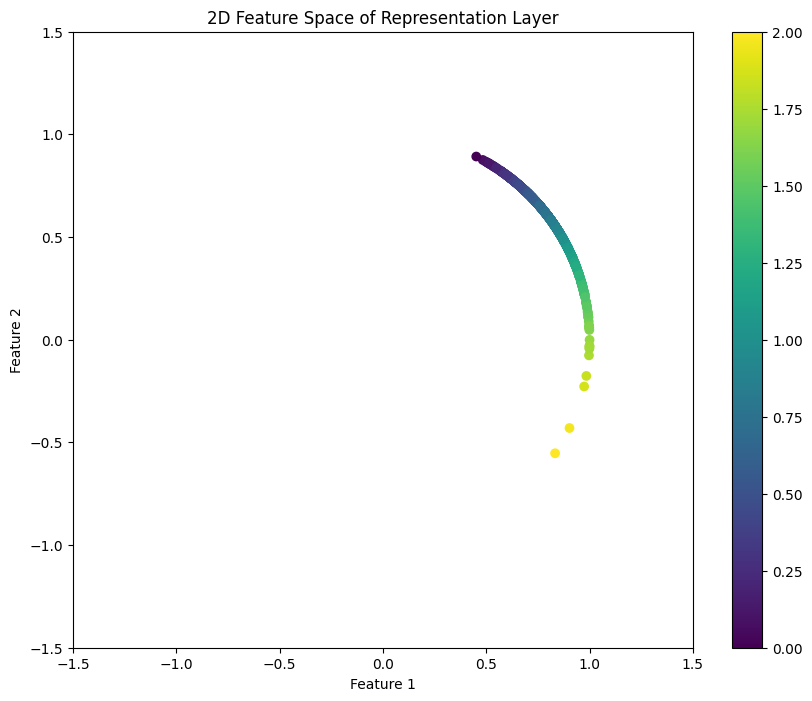

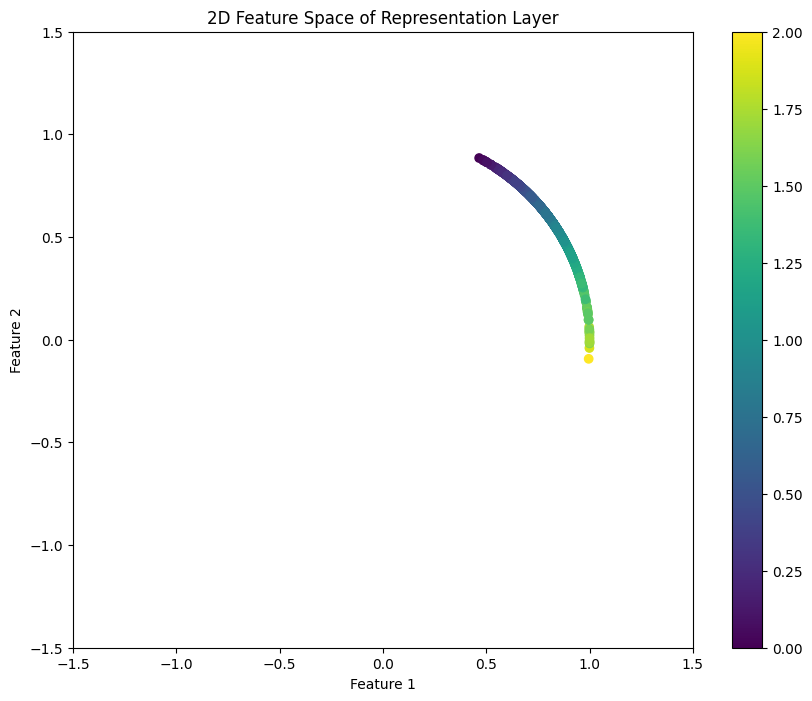

In [10]:
# plot_feature_space(model, X_train, y_train)
# Plot the 2D feature space
eva.plot_feature_space(extended_model, loader.X_train, loader.y_train, withhead=True)
eva.plot_feature_space(extended_model, loader.X_test, loader.y_test, withhead=True)

Mean Squared Error: 0.0004578082007355988
Root Mean Squared Error: 0.02139645256102085


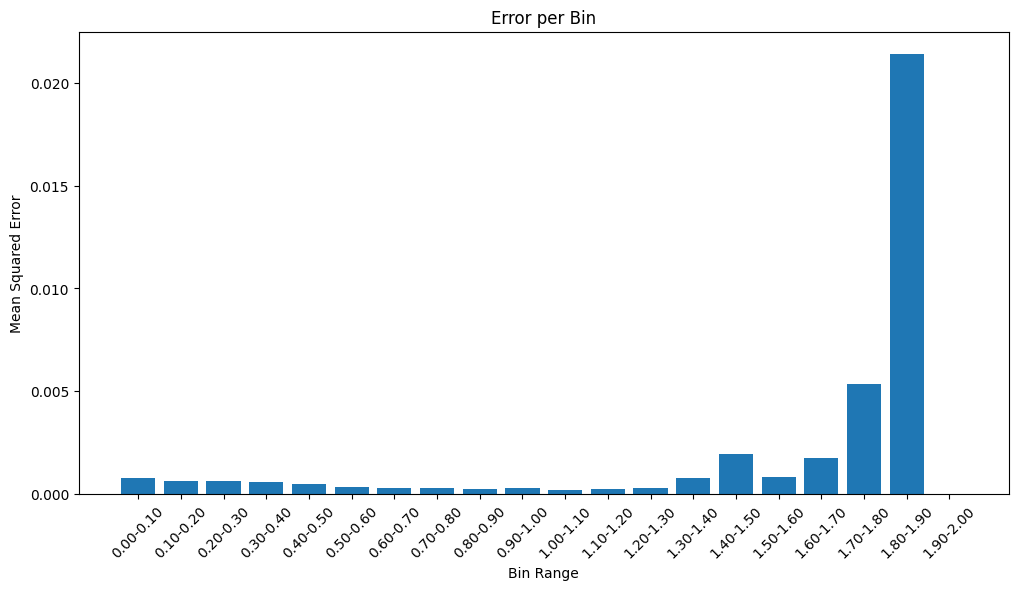

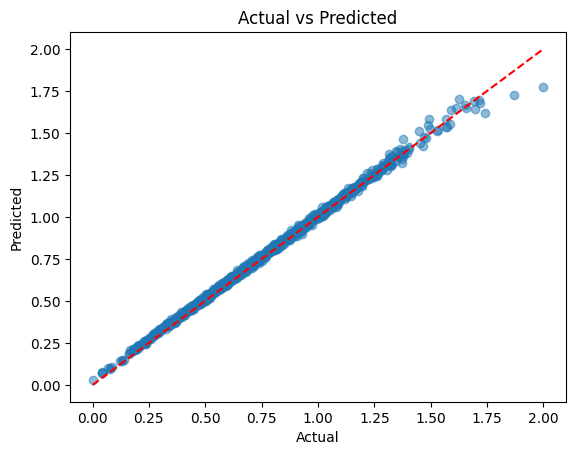

Sample with y = 1.3781939245040011 belongs to bin 14 and has an error of 0.08386259309701205
Sample with y = 1.4914006289943011 belongs to bin 15 and has an error of 0.09252247243086975
Sample with y = 1.739975615093097 belongs to bin 18 and has an error of 0.1185918288916199
Sample with y = 1.870703853135541 belongs to bin 19 and has an error of 0.14640132284684482
Sample with y = 2.0 belongs to bin 21 and has an error of 0.22859013080596924


0.0004578082

In [11]:
eva.evaluate(extended_model, loader.X_test, loader.y_test)

In [ ]:
# option 3 single stage training  training

In [205]:
def bal_custom_loss(y_true, z_pred, reduction=tf.keras.losses.Reduction.NONE):
    """
    Computes the loss for a batch of predicted features and their labels.
    
    :param y_true: A batch of true label values, shape of [batch_size, 1].
    :param z_pred: A batch of predicted Z values, shape of [batch_size, 2].
    :param reduction: The type of reduction to apply to the loss.
    :return: The average error for all unique combinations of the samples in the batch.
    """
    int_batch_size = tf.shape(z_pred)[0]
    batch_size = tf.cast(int_batch_size, dtype=tf.float32)
    total_error = tf.constant(0.0, dtype=tf.float32)

    # Loop through all unique pairs of samples in the batch
    for i in tf.range(int_batch_size):
        for j in tf.range(i + 1, int_batch_size):
            z1, z2 = z_pred[i], z_pred[j]
            # tf.print(z1, z2, sep=', ', end='\n')
            label1, label2 = y_true[i], y_true[j]
            # tf.print(label1, label2, sep=', ', end='\n')
            err = error(z1, z2, label1, label2) * normalized_reweight(label1, label2, min_jpdf, max_jpdf, kde_scott, alpha)
            # tf.print(err, end='\n\n')
            total_error += tf.cast(err, dtype=tf.float32)
    
    # tf.print(total_error)
    
    if reduction == tf.keras.losses.Reduction.SUM:
        return total_error # total loss
    elif reduction == tf.keras.losses.Reduction.NONE:
        denom = tf.cast(batch_size * (batch_size - 1) / 2 + 1e-9, dtype=tf.float32)
        # tf.print(denom)
        return total_error / denom # average loss
    else:
        raise ValueError(f"Unsupported reduction type: {reduction}.")

In [210]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=bal_custom_loss)
history = model_feat.fit(X_train, y_train, epochs=400, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb])  

Epoch 1/400


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/bal_custom_loss/while/gradients/bal_custom_loss/while/while_grad/gradients/AddN_1' defined at (most recent call last):
    File "C:\Users\the_3\anaconda3\envs\aip\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\the_3\anaconda3\envs\aip\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\the_3\AppData\Local\Temp\ipykernel_20060\4249148402.py", line 3, in <module>
      history = model_feat.fit(X_train, y_train, epochs=400, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb])
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/bal_custom_loss/while/gradients/bal_custom_loss/while/while_grad/gradients/AddN_1'
Inputs to operation gradient_tape/bal_custom_loss/while/bal_custom_loss/while_grad/body/_146/gradient_tape/bal_custom_loss/while/gradients/bal_custom_loss/while/while_grad/bal_custom_loss/while/while_grad/body/_591/gradient_tape/bal_custom_loss/while/gradients/bal_custom_loss/while/while_grad/gradients/AddN_1 of type AddN must have the same size and shape.  Input 0: [] != input 1: [1]
	 [[{{node gradient_tape/bal_custom_loss/while/gradients/bal_custom_loss/while/while_grad/gradients/AddN_1}}]] [Op:__inference_train_function_1500125]

In [ ]:
# model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss=custom_loss)
# history = model_feat.fit(X_train, y_train, epochs=25, batch_size=16, callbacks=[tensorboard_cb])

In [ ]:
# get groupings for the labels
# y_concatenated = np.concatenate([y_train, y_test], axis=0)
# groups, min_val, max_val = get_groups(y_concatenated)
# print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# # Plot the 2D feature space
# plot_feature_space(model_feat, X_train, y_train)
# plot_feature_space(model_feat, X_test, y_test)


In [84]:
# Find the indices of the 10 largest values in y_test
indices_of_largest = np.argsort(y_test)[-10:]

# Print the inputs, features, and target values for the 10 instances
for index in indices_of_largest:
    print("Inputs:", X_test[index])
    print("Target Value:", y_test[index])
    print("Feature Value:", model_feat.predict(X_test[index:index+1])) 
    print("---")


Inputs: [-0.66166039 -1.61995567 -1.06960583  2.88804315]
Target Value: 1.6904130218645055
Feature Value: [[0.8633523  0.50460166]]
---
Inputs: [-2.91257518  1.73507251  0.45326313  0.9587324 ]
Target Value: 1.6955549929842646
Feature Value: [[0.82978034 0.55809   ]]
---
Inputs: [-0.85118267  2.15820617  2.4051415   1.33724711]
Target Value: 1.719677408170317
Feature Value: [[0.8365724  0.54785645]]
---
Inputs: [-2.25891844  1.12559813 -0.86486169 -2.44761518]
Target Value: 1.730535070717517
Feature Value: [[0.8849439  0.46569756]]
---
Inputs: [ 2.4128958  -2.19341696 -1.03374832 -1.29864882]
Target Value: 1.7502027344386148
Feature Value: [[0.8944102 0.4472477]]
---
Inputs: [-0.1723927   0.21030117  1.94944472  3.22703691]
Target Value: 1.812099399331439
Feature Value: [[0.88738674 0.46102586]]
---
Inputs: [ 2.31641503 -1.30201463 -1.72802956  2.121885  ]
Target Value: 1.8297171438583253
Feature Value: [[0.9065625  0.42207146]]
---
Inputs: [-2.18439182  2.06790111 -1.68644684  1.98027

In [86]:
# Count the samples in each bin for the test set
count_samples_in_bins(y_test)
# This confirms that the test set is normally distributed around .9 where 
# both values very close to 0 and 2 are very rare so they are separated in feature space
# Why values close to zero are as rare?
# when considering the standard gaussian density function,
# to have a norm close to zero, you need to have all 4 features close to zero
# which means the interval over which the density function is integrated is very small
# the bins reflect that.

Bin 0 (0.0 to 0.1): 9 samples
Bin 1 (0.1 to 0.2): 19 samples
Bin 2 (0.2 to 0.3): 26 samples
Bin 3 (0.3 to 0.4): 53 samples
Bin 4 (0.4 to 0.5): 81 samples
Bin 5 (0.5 to 0.6): 96 samples
Bin 6 (0.6 to 0.7): 113 samples
Bin 7 (0.7 to 0.8): 120 samples
Bin 8 (0.8 to 0.9): 114 samples
Bin 9 (0.9 to 1.0): 79 samples
Bin 10 (1.0 to 1.1): 64 samples
Bin 11 (1.1 to 1.2): 71 samples
Bin 12 (1.2 to 1.3): 46 samples
Bin 13 (1.3 to 1.4): 41 samples
Bin 14 (1.4 to 1.5): 25 samples
Bin 15 (1.5 to 1.6): 27 samples
Bin 16 (1.6 to 1.7): 8 samples
Bin 17 (1.7 to 1.8): 3 samples
Bin 18 (1.8 to 1.9): 2 samples
Bin 19 (1.9 to 2.0): 3 samples


In [87]:
# Count the samples in each bin for the training set
count_samples_in_bins(y_train)

Bin 0 (0.0 to 0.1): 8 samples
Bin 1 (0.1 to 0.2): 24 samples
Bin 2 (0.2 to 0.3): 47 samples
Bin 3 (0.3 to 0.4): 65 samples
Bin 4 (0.4 to 0.5): 92 samples
Bin 5 (0.5 to 0.6): 106 samples
Bin 6 (0.6 to 0.7): 116 samples
Bin 7 (0.7 to 0.8): 109 samples
Bin 8 (0.8 to 0.9): 108 samples
Bin 9 (0.9 to 1.0): 98 samples
Bin 10 (1.0 to 1.1): 72 samples
Bin 11 (1.1 to 1.2): 54 samples
Bin 12 (1.2 to 1.3): 46 samples
Bin 13 (1.3 to 1.4): 27 samples
Bin 14 (1.4 to 1.5): 12 samples
Bin 15 (1.5 to 1.6): 9 samples
Bin 16 (1.6 to 1.7): 4 samples
Bin 17 (1.7 to 1.8): 1 samples
Bin 18 (1.8 to 1.9): 1 samples
Bin 19 (1.9 to 2.0): 1 samples


In [88]:
# why are the green and yellow points mixed up?
# mixup happens mostly for large values of y (close to 2), rare samples
# no mixup in training set feature space but mixup in test set feature space for rare samples
# this might be due to imbalance for rare sample
# TODO: test it with balanced dataset

In [ ]:
# to have better features, not do balancing
# Try option 2: don't balance features but finetune with the regression stage which will be balanced the mixup green and yellows
# Try option 3: calculate losses separately and find the ratio over multiple epochs (estimate the entire  thing) reduce the number of magic numbers
# if they grow the same (same function) and you know the range, you can determine the ratio, divide by 4 for feature mse (one stage in option 3 is a magic number)
# given a input batch, the neural net 2 batches: features batch and label batch (2 batches are not related)
# do density in constant preprocessing and look it up as tensorflow constant - hash table with real multiplied by million